In [ ]:
import math
import numpy as np
import pandas as pd
import itertools

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import optimizers, models, layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image, ImageEnhance

from keras.utils import np_utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/pics.csv")
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

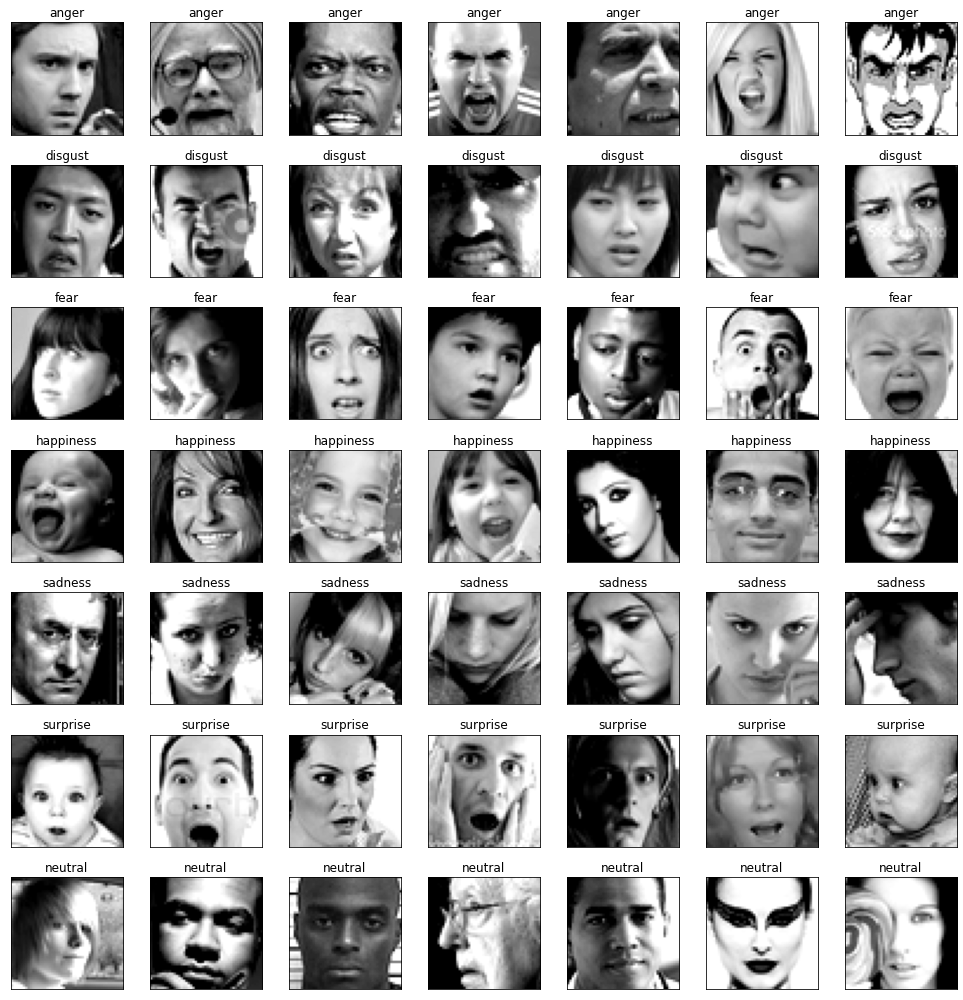

In [ ]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('uint8')

        enhancer = ImageEnhance.Contrast(Image.fromarray(px))
        factor = 1.5
        im = enhancer.enhance(factor)
        px = np.array(im).astype("float32")

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


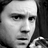

In [ ]:
# Increasing the contrast of all the images

for i in range(df.shape[0]):
    arr = df.pixels.iloc[i]
    arr = np.array(arr.split(' ')).reshape(48, 48).astype('uint8')
    enhancer = ImageEnhance.Contrast(Image.fromarray(arr))
    factor = 1.5
    im = enhancer.enhance(factor)
    if i == 0:
        img = im
    arr = np.array(im).astype("uint8")
    df.pixels.iloc[i] = arr

img

In [ ]:
# Splitting the dataset for training and testing
img_array = df.pixels.apply(lambda x: x.reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
print(img_array.shape)
img_labels = df.emotion

(35887, 48, 48, 1)


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(img_array, img_labels, shuffle = True, stratify = img_labels, test_size=0.3, random_state = 42)

print(x_train)

# Normalize pixel values between 0 and 1
x_train, x_valid = x_train / 255.0, x_valid / 255.0
print(x_train.shape)

# Reshaping image into the readable shape
x_train = x_train.reshape(-1, 48, 48, 1)
x_valid = x_valid.reshape(-1, 48, 48, 1)

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

[[[[242.]
   [232.]
   [190.]
   ...
   [ 40.]
   [ 31.]
   [ 28.]]

  [[250.]
   [209.]
   [149.]
   ...
   [ 71.]
   [ 55.]
   [ 41.]]

  [[239.]
   [164.]
   [119.]
   ...
   [ 64.]
   [ 47.]
   [ 43.]]

  ...

  [[ 89.]
   [ 94.]
   [ 41.]
   ...
   [ 13.]
   [ 22.]
   [  0.]]

  [[ 41.]
   [119.]
   [ 59.]
   ...
   [ 40.]
   [ 28.]
   [  0.]]

  [[  4.]
   [ 86.]
   [131.]
   ...
   [ 89.]
   [ 41.]
   [  4.]]]


 [[[141.]
   [131.]
   [149.]
   ...
   [  0.]
   [  0.]
   [  0.]]

  [[147.]
   [150.]
   [156.]
   ...
   [  0.]
   [  0.]
   [  0.]]

  [[159.]
   [168.]
   [165.]
   ...
   [  0.]
   [  0.]
   [  0.]]

  ...

  [[237.]
   [204.]
   [191.]
   ...
   [ 90.]
   [ 84.]
   [ 81.]]

  [[228.]
   [212.]
   [194.]
   ...
   [101.]
   [ 81.]
   [ 80.]]

  [[194.]
   [224.]
   [191.]
   ...
   [104.]
   [ 78.]
   [ 72.]]]


 [[[  0.]
   [  0.]
   [  0.]
   ...
   [232.]
   [225.]
   [213.]]

  [[  0.]
   [  0.]
   [  0.]
   ...
   [226.]
   [217.]
   [201.]]

  [[  0.]
   [  

((25120, 48, 48, 1), (10767, 48, 48, 1), (25120,), (10767,))

In [ ]:
# Defining the CNN architecture using relu activation function as we want to avoid negative values
model = models.Sequential()

# Adding a convolution layer with 50 filters each of dimension 3x3
model.add(layers.Conv2D(32, (3, 3), activation='elu', input_shape=(48, 48, 1)))

model.add(BatchNormalization(name='batchnorm_1'))

# Adding a convolution layer with 50 filters each of dimension 3x3
model.add(layers.Conv2D(64, (3, 3), activation='elu'))

# Using max pooling with kernel dimensions 2x2
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.4, name='dropout_1'))

# Adding a convolution layer with 100 filters each of dimension 3x3
model.add(layers.Conv2D(64, (3, 3), activation='elu'))

model.add(BatchNormalization(name='batchnorm_2'))

# Adding a convolution layer with 50 filters each of dimension 3x3
model.add(layers.Conv2D(128, (3, 3), activation='elu'))

# Using max pooling with kernel dimensions 2x2
model.add(layers.MaxPooling2D((2, 2)))

# Adding a convolution layer with 100 filters each of dimension 3x3
model.add(layers.Conv2D(128, (3, 3), activation='elu'))

model.add(BatchNormalization(name='batchnorm_3'))

# Using max pooling with kernel dimensions 2x2
model.add(layers.MaxPooling2D((2, 2)))

# Flattening the data to one dimension
model.add(layers.Flatten())
model.add(Dropout(0.6, name='dropout_2'))
# Adding a dense layer with 100 nodes which has high interconnection of nodes
model.add(layers.Dense(128, activation='relu'))

# Defining the output layer
model.add(layers.Dense(7,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 46, 46, 32)       128       
 tion)                                                           
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        3

'\nThis is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.\nI used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu\natleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better\nresults.\n'

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)
callbacks = [
    early_stopping
]



In [ ]:
# Training the model using the adam optimizer
model.compile(optimizer = 'nadam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics=['accuracy'])

# Fitting the data into the model
history = model.fit(x_train, y_train, epochs = 1000, validation_data=(x_valid, y_valid),callbacks = callbacks)

Epoch 1/1000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


785/785 [==============================] - 446s 565ms/step - loss: 1.7315 - accuracy: 0.3338 - val_loss: 1.4535 - val_accuracy: 0.4285
Epoch 2/1000
785/785 [==============================] - 438s 558ms/step - loss: 1.4674 - accuracy: 0.4296 - val_loss: 1.3531 - val_accuracy: 0.4772
Epoch 3/1000
785/785 [==============================] - 434s 553ms/step - loss: 1.3594 - accuracy: 0.4780 - val_loss: 1.2919 - val_accuracy: 0.5037
Epoch 4/1000
785/785 [==============================] - 436s 555ms/step - loss: 1.2941 - accuracy: 0.5070 - val_loss: 1.2636 - val_accuracy: 0.5117
Epoch 5/1000
785/785 [==============================] - 433s 552ms/step - loss: 1.2470 - accuracy: 0.5267 - val_loss: 1.2088 - val_accuracy: 0.5356
Epoch 6/1000
785/785 [==============================] - 433s 552ms/step - loss: 1.2023 - accuracy: 0.5438 - val_loss: 1.1709 - val_accuracy: 0.5562
Epoch 7/1000
785/785 [==============================] - 431s 549ms/step - loss: 1.1648 - accuracy: 0.5584 - val_loss: 1.1534 

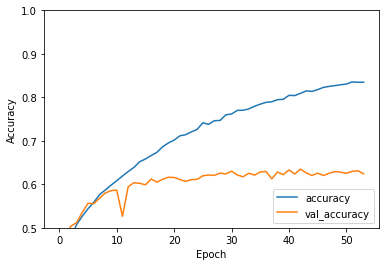

In [ ]:
# Testing and Evaluating 
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
print("accuracy =" , history.history['accuracy'][4])

accuracy = 0.5267117619514465


337/337 [==============================] - 42s 125ms/step - loss: 1.1819 - accuracy: 0.6349
Final test set loss: 1.181921
Final test set accuracy: 0.634903
337/337 [==============================] - 42s 124ms/step


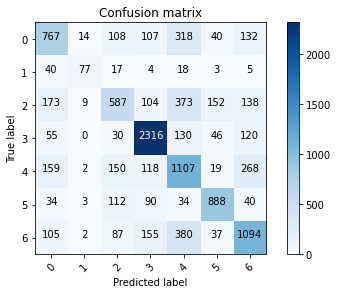

In [ ]:
# Calculating model accuracy using testing dataset
results = model.evaluate(x_valid, y_valid)
print('Final test set loss: {:4f}'.format(results[0]))
print('Final test set accuracy: {:4f}'.format(results[1]))

predictions = model.predict(x_valid)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Making the confusion matrix
confusion_mtx = confusion_matrix(y_valid, np.argmax(predictions, axis = 1)) 
# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))